In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
import time as tm
# Custom libraries
import CCM_GAH_lib as ccm
import data_handle_lib as dh

### Read mgp93 data
(from this study https://www.mg-rast.org/mgmain.html?mgpage=project&project=mgp93)

In [2]:
data_path = 'data/mgp93_data_genus.tsv'
metadata_path = 'data/mgp93_metadata.csv'

raw_data, raw_metadata, metadata_descr = dh.read_raw_data(data_path, metadata_path)
df_mgp93 = dh.merge_data(raw_data, raw_metadata)

### Clean up

(include these in the .py library later)

In [3]:
# Select data for a certain subject and sample location
df_data_M_gut = df_mgp93[((df_mgp93.host_individual == 'M3') | (df_mgp93['host_individual'].isnull()))
                       & ((df_mgp93.common_sample_site == 'feces') | (df_mgp93['common_sample_site'].isnull()))]

data_range = np.arange(6, df_data_M_gut.shape[1])
how_many_species = 10
only_most_abundant = True

# Select only the most abundant
if(only_most_abundant):
    total_species = df_data_M_gut.loc[0:, df_data_M_gut.columns[data_range]].sum(axis=0)
    data_range = (total_species.sort_values(ascending=False).index.values).astype(int)[0:how_many_species]
    
df_1 = pd.concat([df_data_M_gut.iloc[:, 0:4], df_data_M_gut.loc[:, data_range]], axis=1)

### Plot
Absolute values:

In [4]:
# Plot absolute values
y_genus = df_1.loc[0:, data_range]
time = df_1.loc[0:, data_range].index.values
legend_list = df_1.loc[:, data_range].loc[df_1['sample_name'] == 'genus'].values[0]

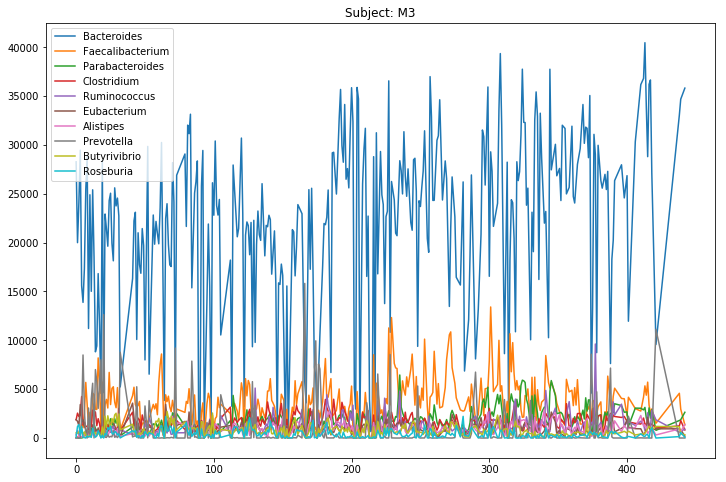

In [5]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)
#ax.set_yscale('log')
plt.plot(time, y_genus)
plt.legend(legend_list)
plt.title('Subject: M3')
plt.show()

Normalized values:

In [6]:
%%capture 

df_1_norm = df_1.copy()
df_1_norm.loc[0:, data_range] = dh.df_normalize(df_1_norm.loc[0:, data_range], along_row = True)

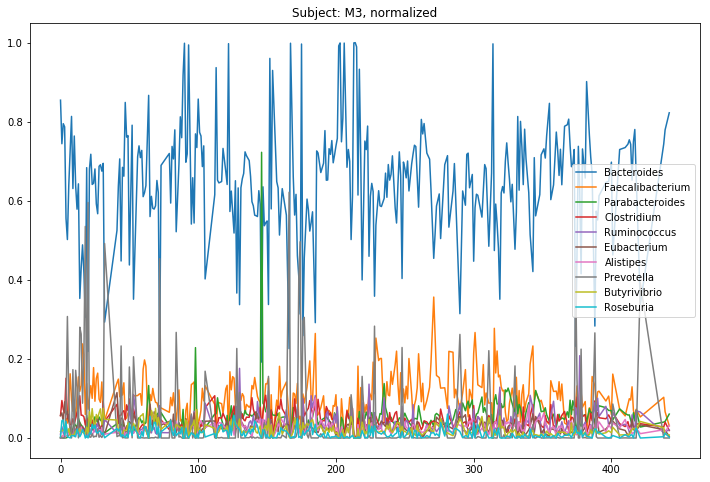

In [7]:
y_genus_norm = df_1_norm.loc[0:, data_range]
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)
plt.plot(time, y_genus_norm)
plt.legend(legend_list)
plt.title('Subject: M3, normalized')
plt.show()

### Do some CCM

<font color=red>NOTE of caution:</font> Observe the difference between the length of the time series, L, and the time at which the samples were taken (so time).

At first sight, it may seem that the two are the same. However, the samples are taken <u>approximately</u> everyday (some samples were dropped because they were mislabeled, for ex), so the length of the time series is not the same as the time. 

To avoid making this mistake, look at the following code that selects the first column of data:

y_genus_norm.iloc[:, k].iloc[:i]).values

A naive mistake is to use .loc[:i], but that simply selects the data based on the index (so time). Another mistake is to pass the data as pandas.Series. The CCM algorithm works with numpy.arrays. You can pass pandas.series as numpy arrays by using .values (otherwise the CCM code would still select the data based on index: someArray[i] selects the i-th element of the numpy.array someArray, whereas somePanda[i] selects the element with index i of the pandas data series somePanda).

That's all, just be careful.

<font color=red>/NOTE</font>

In [8]:
# CCM constants

E = 3 # CCM embedding dimension
# Time-series lengths L for which to do CCM and compute correlation coeff.
#L = time[8:32].astype(int)
L_max = len(y_genus_norm)
L_step = 5
L = np.arange(E+4, L_max, L_step)
if (L[-1] != len(y_genus_norm)):
    np.append(L, len(y_genus_norm))

Loop (0, 1) took 38.421 seconds.


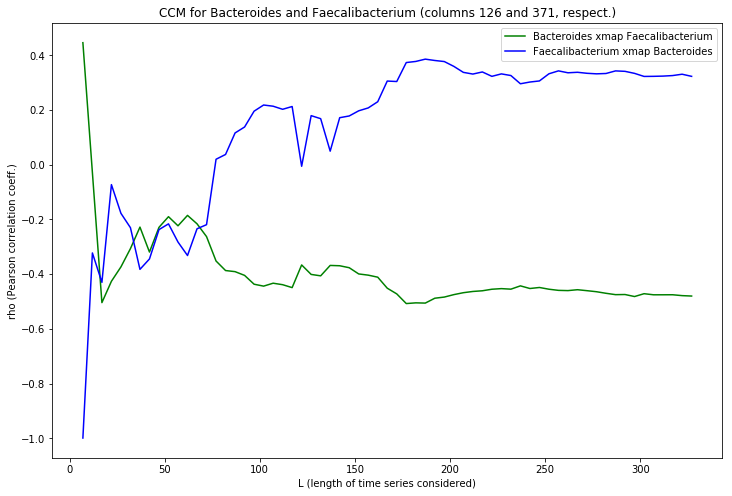

Loop (0, 2) took 40.481 seconds.


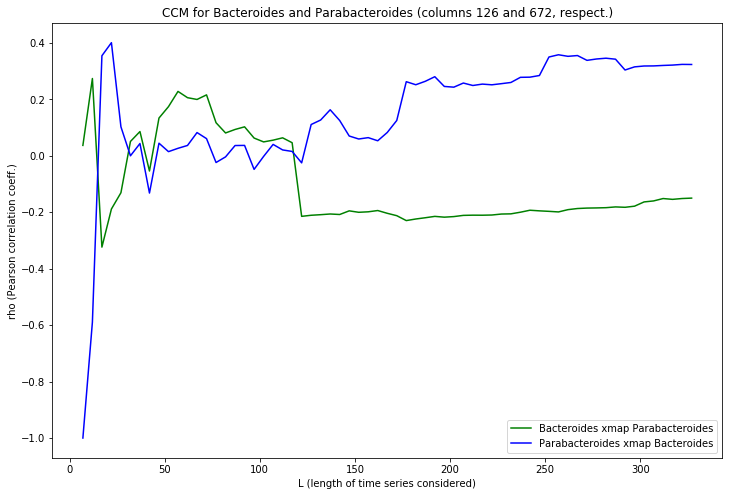

Loop (1, 2) took 41.067 seconds.


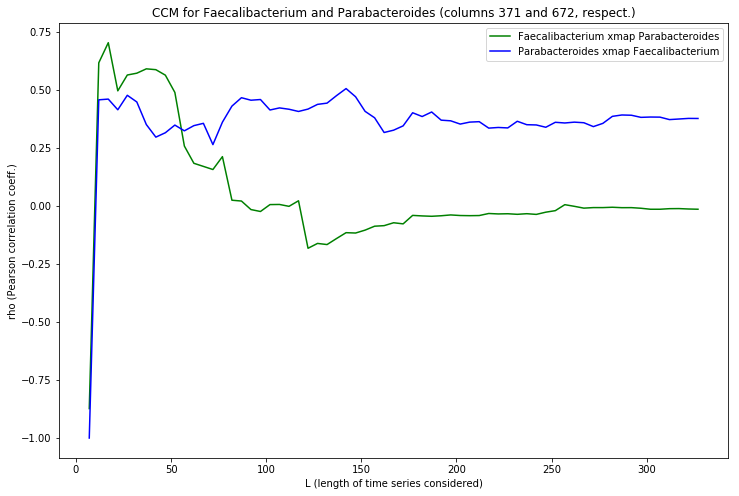

In [9]:
how_many_cols = 3 #y_genus_norm.shape[1]-1
for m in range(how_many_cols):
    for n in np.arange(m+1, how_many_cols):
        start_time = tm.time()
    
        corr_X_xmap_Y, corr_Y_xmap_X = [], []
        x_posit, y_posit = m, n
        x_ID, y_ID = y_genus_norm.iloc[:,x_posit].name, y_genus_norm.iloc[:,y_posit].name
        x_name, y_name = df_1_norm.loc[df_1_norm['sample_name'] == "genus"].loc[:, [x_ID, y_ID]].values[0]
 
        for i in L:
            x_orig = (y_genus_norm.iloc[:, x_posit].iloc[:i]).values
            y_orig = (y_genus_norm.iloc[:, y_posit].iloc[:i]).values
        
            #print("I am here %s" %(i))
            Y_approx = ccm.generateYApprox(x_orig, x_orig, E=E, how_long=0)  
            corr_Y_xmap_X.append(pearsonr(y_orig[(E-1):i], Y_approx)[0]) 
        
            X_approx = ccm.generateYApprox(y_orig, x_orig, E=E, how_long=0)  
            corr_X_xmap_Y.append(pearsonr(x_orig[(E-1):], X_approx)[0])
    
        end_time = tm.time()
        print("Loop (%s, %s) took %.3f seconds." %(m, n, end_time-start_time))
    
        fig = plt.figure(figsize=(12,8))
        plt.plot(L, corr_Y_xmap_X, 'g')
        plt.plot(L, corr_X_xmap_Y, 'b')
        plt.title("CCM for %s and %s (columns %s and %s, respect.)" %(x_name, y_name, x_ID, y_ID))
        plt.legend(["%s xmap %s"%(x_name, y_name), "%s xmap %s"%(y_name, x_name)])
        #plt.ylim([0,1])
        plt.xlabel("L (length of time series considered)")
        plt.ylabel("rho (Pearson correlation coeff.)")
        plt.show()